In [1]:
from qtpg.team import Team
from qtpg.learner import Learner
from qtpg.program import Program
from qtpg.rule import Rule
from qtpg.figure13 import Figure13
from qtpg.figure13_hole_in_wall import Figure13HoleInWall
from qtpg.figure12 import Figure12
from qtpg.figure9 import Figure9
from qtpg.search_manager import SearchManager
import numpy as np
import uuid
import copy
import matplotlib.pyplot as plt

In [2]:
# env params
memorySize = 40
legalMove = 0.1
illegalMove = -0.01
outOfBounds = 0.0
memoryRepeat = -0.01
# memoryRepeat = 0.0
goalReached = 100

# envName = 'Figure 13'
# env = Figure13(5, 5, (2, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Figure 13 Hole in Wall'
# env = Figure13HoleInWall(5, 5, (2, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Figure 12'
# env = Figure12(5, 5, (4, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
envName = 'Figure 9'
env = Figure9(10, 10, (4, 9), (0, 3), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)

In [3]:
numGens = 200
# numGens = 30
maxTeamPool = 5
runs = 1
# init search manager and starting teams

# searchManager = SearchManager(maxTeamPool)

# variables for tracking fitness, for curves
scores = []
gens = []
maxes = []
averages = []
mins = []

run_winners = []
runs_score_track = []

for run in range(runs):
    maxes = []
    averages = []
    mins = []
    gens = []
    print(run)
    # init everything for new run
    searchManager = SearchManager(maxTeamPool)
    
    adam_and_eve = []
    env.reset()
    init_team = Team(uuid.uuid4(), 0, 0, 1, 1, 0)
    init_team.init_search(env, [2, 3])
    adam_and_eve.append(init_team)
#     init_team = Team(uuid.uuid4(), 0, 0, 1, 1, 0)
#     init_team.init_search(env, [0, 1])
#     adam_and_eve.append(init_team)
    win = False
    for adam in adam_and_eve:
        data = [adam, win]
        searchManager.evaluate_team(data)
    
    
    for gen in range(numGens):
        print('winners so far:')
        print(searchManager.winners)
        print(f'GEN --> {gen}')
    #     if win:
    #         print(f'got to --> gen {gen+1}')
    #         break
        toEvaluateAfterGen = []
        scores = []
#         print(f'>>>>>>>>>>>>>>>>>>>>>>>Gen {gen+1} start!>>>>>>>>>>>>>>>>>>>>>>>')
        # get it started
        for parent in searchManager.teamPool:
            # only run if the team has not yet won
            if parent not in searchManager.winners:
#                 print(f'Parent: {parent.id}')
        #             print(f'Start: {parent.start_state}')
                env.current_state = parent.start_state

                # make offspring from parent, then let that offspring make a new rule
                child = copy.deepcopy(parent)
                child.id = uuid.uuid4()
                win = child.search_no_back_track(env)
#                 print(f'Child: {child.id}')
#                 print('Start Child Regions --------')
#                 for learner in child.learners:
#                     print(learner.program.rule.region)
#                 print('End Child Regions --------')
#                 print(f'Child Fitness: {child.fitness}') 
                toEvaluateAfterGen.append([child, win])
                scores.append(child)
            else:
#                 print(f'Skipping Team: {parent.id}')
#                 print(parent.fitness)
                scores.append(parent)

        for data in toEvaluateAfterGen:
            searchManager.evaluate_team(data)
#         print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
#         print(f'End of Gen {gen+1} Regions')
#         for i in range(len(searchManager.teamPool)):
#             print(f'Team: {i+1} --> {searchManager.teamPool[i].fitness}')
#             for learner in searchManager.teamPool[i].learners:
#                 print(learner.program.rule.region)
#         print(f'>>>>>>>>>>>>>>>>>>>>>>>Gen {gen+1} end!>>>>>>>>>>>>>>>>>>>>>>>')
        # start: manage fitness curves (at end of gen)
        gens.append(gen)
        total = 0
        max_fitness = -100
        min_fitness = 100

        for team in scores:
            total += team.fitness
            if team.fitness > max_fitness:
                max_fitness = team.fitness
            if team.fitness < min_fitness:
                min_fitness = team.fitness
        average_fitness = total / len(searchManager.teamPool)
        maxes.append(max_fitness)
        averages.append(average_fitness)
        mins.append(min_fitness)

#         team_index = 0
#         for team in searchManager.teamPool:
#             team_index += 1
#             print(f'Team: {team_index} regions -- ', end='')
#             for learner in team.learners:
#                 print(f'{learner.program.rule.region}, ', end='')
#             print(f'fitness -- {team.fitness}')
#             print('')
    runs_score_track.append({'run': run, 'maxes': maxes, 'averages': averages, 'mins': mins})
        # end: manage fitness curves (at end of gen)
#     for team in searchManager.winners:
#         print('$$$$$$$$$$$$$ winnnnnner start $$$$$$$$$$$$$$$$$$$$')
#         print(team.fitness)
#         print('Learners:')
#         for learner in team.learners:
#             print(f'Region: {learner.program.rule.region} --> Action: {learner.program.rule.action_set}')
#         print('$$$$$$$$$$$$$ winnnnnner end $$$$$$$$$$$$$$$$$$$$')
    
    run_winners.append({'run': run, 'winners': searchManager.winners})

0
winners so far:
[]
GEN --> 0
winners so far:
[]
GEN --> 1
winners so far:
[]
GEN --> 2
winners so far:
[]
GEN --> 3
winners so far:
[]
GEN --> 4
winners so far:
[]
GEN --> 5
winners so far:
[]
GEN --> 6
winners so far:
[]
GEN --> 7
winners so far:
[]
GEN --> 8
winners so far:
[]
GEN --> 9
winners so far:
[]
GEN --> 10
winners so far:
[]
GEN --> 11
winners so far:
[]
GEN --> 12
winners so far:
[]
GEN --> 13
winners so far:
[]
GEN --> 14
winners so far:
[]
GEN --> 15
winners so far:
[]
GEN --> 16
winners so far:
[]
GEN --> 17
winners so far:
[]
GEN --> 18
winners so far:
[]
GEN --> 19
winners so far:
[]
GEN --> 20
winners so far:
[]
GEN --> 21
winners so far:
[]
GEN --> 22
winners so far:
[]
GEN --> 23
winners so far:
[]
GEN --> 24
winners so far:
[]
GEN --> 25
winners so far:
[]
GEN --> 26
winners so far:
[]
GEN --> 27
winners so far:
[]
GEN --> 28
winners so far:
[]
GEN --> 29
winners so far:
[]
GEN --> 30
winners so far:
[]
GEN --> 31
winners so far:
[]
GEN --> 32
winners so far:
[]

winners so far:
[<qtpg.team.Team object at 0x7fb5529b0e50>, <qtpg.team.Team object at 0x7fb55289ab50>, <qtpg.team.Team object at 0x7fb552989760>]
GEN --> 113
winners so far:
[<qtpg.team.Team object at 0x7fb5529b0e50>, <qtpg.team.Team object at 0x7fb55289ab50>, <qtpg.team.Team object at 0x7fb552989760>]
GEN --> 114
winners so far:
[<qtpg.team.Team object at 0x7fb5529b0e50>, <qtpg.team.Team object at 0x7fb55289ab50>, <qtpg.team.Team object at 0x7fb552989760>]
GEN --> 115
winners so far:
[<qtpg.team.Team object at 0x7fb5529b0e50>, <qtpg.team.Team object at 0x7fb55289ab50>, <qtpg.team.Team object at 0x7fb552989760>]
GEN --> 116
winners so far:
[<qtpg.team.Team object at 0x7fb5529b0e50>, <qtpg.team.Team object at 0x7fb55289ab50>, <qtpg.team.Team object at 0x7fb552989760>]
GEN --> 117
winners so far:
[<qtpg.team.Team object at 0x7fb5529b0e50>, <qtpg.team.Team object at 0x7fb55289ab50>, <qtpg.team.Team object at 0x7fb552989760>]
GEN --> 118
winners so far:
[<qtpg.team.Team object at 0x7fb5529

winners so far:
[<qtpg.team.Team object at 0x7fb5529b0e50>, <qtpg.team.Team object at 0x7fb55289ab50>, <qtpg.team.Team object at 0x7fb552989760>, <qtpg.team.Team object at 0x7fb5528f0ca0>]
GEN --> 160
winners so far:
[<qtpg.team.Team object at 0x7fb5529b0e50>, <qtpg.team.Team object at 0x7fb55289ab50>, <qtpg.team.Team object at 0x7fb552989760>, <qtpg.team.Team object at 0x7fb5528f0ca0>]
GEN --> 161
winners so far:
[<qtpg.team.Team object at 0x7fb5529b0e50>, <qtpg.team.Team object at 0x7fb55289ab50>, <qtpg.team.Team object at 0x7fb552989760>, <qtpg.team.Team object at 0x7fb5528f0ca0>]
GEN --> 162
winners so far:
[<qtpg.team.Team object at 0x7fb5529b0e50>, <qtpg.team.Team object at 0x7fb55289ab50>, <qtpg.team.Team object at 0x7fb552989760>, <qtpg.team.Team object at 0x7fb5528f0ca0>]
GEN --> 163
winners so far:
[<qtpg.team.Team object at 0x7fb5529b0e50>, <qtpg.team.Team object at 0x7fb55289ab50>, <qtpg.team.Team object at 0x7fb552989760>, <qtpg.team.Team object at 0x7fb5528f0ca0>]
GEN -->

In [4]:
#fitness curves
# x = []
# y = []
# for gen in gens:
#     x.append(gen)

# for average in averages:
#     y.append(average)
# plt.xlabel('Generation')
# plt.ylabel('Average Score')
# plt.plot(x, y)
# plt.show()

In [5]:
# #fitness curves
# x = []
# y = []
# for gen in gens:
#     x.append(gen)

# for max_ in maxes:
#     y.append(max_)
# plt.xlabel('Generation')
# plt.ylabel('Max Score')
# plt.plot(x, y)
# plt.show()

In [6]:
for team in searchManager.winners:
    print('$$$$$$$$$$$$$ winnnnnner start $$$$$$$$$$$$$$$$$$$$')
    print(team.fitness)
    print('Learners:')
    for learner in team.learners:
        print(f'Region: {learner.program.rule.region} --> Action: {learner.program.rule.action_set}')
    print('$$$$$$$$$$$$$ winnnnnner end $$$$$$$$$$$$$$$$$$$$')

$$$$$$$$$$$$$ winnnnnner start $$$$$$$$$$$$$$$$$$$$
152.44
Learners:
Region: [0, 0, 1, 4] --> Action: [2, 3]
Region: [1, 0, 0, 4] --> Action: [0, 1]
Region: [1, 0, 6, 9] --> Action: [0, 1]
Region: [0, 5, 0, 1] --> Action: [2, 3]
Region: [0, 5, 3, 7] --> Action: [2, 3]
Region: [1, 2, 5, 8] --> Action: [0, 1]
Region: [0, 9, 0, 2] --> Action: [2, 3]
Region: [0, 9, 4, 9] --> Action: [2, 3]
Region: [1, 3, 5, 8] --> Action: [0, 1]
Region: [0, 9, 0, 6] --> Action: [2, 3]
Region: [0, 9, 8, 9] --> Action: [2, 3]
Region: [1, 7, 0, 2] --> Action: [0, 1]
Region: [1, 7, 4, 9] --> Action: [0, 1]
Region: [0, 3, 7, 7] --> Action: [2, 3]
Region: [1, 6, 0, 4] --> Action: [0, 1]
Region: [0, 5, 0, 3] --> Action: [2, 3]
Region: [0, 5, 5, 7] --> Action: [2, 3]
Region: [1, 4, 5, 7] --> Action: [0, 1]
Region: [1, 4, 9, 9] --> Action: [0, 1]
Region: [0, 8, 1, 5] --> Action: [2, 3]
Region: [1, 0, 0, 0] --> Action: [0, 1]
Region: [1, 0, 2, 9] --> Action: [0, 1]
Region: [0, 1, 1, 4] --> Action: [2, 3]
Region: [1,

## Average Max Fitness Curves

In [7]:
print(runs_score_track[0]['maxes'][0])
print(len(runs_score_track))
print(len(runs_score_track[0]))
print(len(runs_score_track[0]['maxes']))

1.03
1
4
200


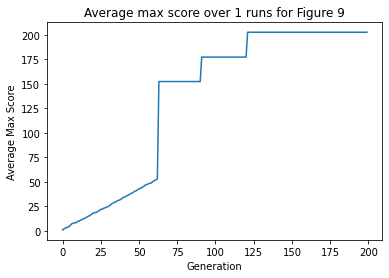

In [8]:
#fitness curves
x = []
y = []
average_maxes = np.zeros(numGens)
# average_maxes = np.zeros(100)

for i in range(len(gens)):
    for q in range(len(runs_score_track)):
        average_maxes[i] += runs_score_track[q]['maxes'][i]
    average_maxes[i] /= len(runs_score_track)
    
for gen in gens:
    x.append(gen)

plt.title(f'Average max score over {len(runs_score_track)} runs for {envName}')
plt.xlabel('Generation')
plt.ylabel('Average Max Score')
plt.plot(x, average_maxes)
plt.show()

## Reinforcement Learning + Victory Lap

In [9]:
print(run_winners)
for learner in team.learners:
    print(learner.program.rule.region)

[{'run': 0, 'winners': [<qtpg.team.Team object at 0x7fb5529b0e50>, <qtpg.team.Team object at 0x7fb55289ab50>, <qtpg.team.Team object at 0x7fb552989760>, <qtpg.team.Team object at 0x7fb5528f0ca0>]}]
[0, 0, 1, 4]
[1, 0, 0, 4]
[1, 0, 6, 9]
[0, 5, 0, 1]
[0, 5, 3, 7]
[1, 2, 5, 8]
[0, 9, 0, 2]
[0, 9, 4, 9]
[1, 3, 5, 8]
[0, 9, 0, 6]
[0, 9, 8, 9]
[1, 7, 0, 2]
[1, 7, 4, 9]
[0, 3, 7, 7]
[1, 6, 0, 4]
[0, 5, 0, 3]
[0, 5, 5, 7]
[1, 4, 5, 7]
[1, 4, 9, 9]
[0, 8, 1, 5]
[1, 0, 0, 0]
[1, 0, 2, 9]
[0, 1, 1, 4]
[1, 0, 0, 5]
[1, 0, 7, 9]
[0, 6, 0, 1]
[0, 6, 3, 5]
[1, 2, 6, 9]
[0, 5, 0, 3]
[0, 5, 5, 7]
[1, 4, 5, 8]
[0, 9, 0, 5]
[0, 9, 7, 9]
[1, 6, 9, 9]
[0, 9, 0, 1]
[0, 9, 3, 9]
[1, 2, 5, 8]
[0, 9, 0, 6]
[0, 9, 8, 9]
[1, 7, 0, 4]
[1, 7, 6, 9]
[0, 5, 0, 0]
[0, 5, 2, 7]
[1, 1, 0, 8]
[0, 9, 1, 9]
[1, 0, 0, 7]
[1, 0, 9, 9]
[0, 8, 0, 1]
[0, 8, 3, 5]
[1, 2, 5, 5]
[1, 2, 7, 9]
[0, 6, 1, 5]
[1, 0, 0, 5]
[1, 0, 7, 9]
[0, 6, 0, 1]
[0, 6, 3, 5]
[1, 2, 6, 9]
[0, 5, 1, 7]
[1, 0, 0, 2]
[1, 0, 4, 9]
[0, 3, 0, 0]
[0, 3, 2,

In [10]:
# team = searchManager.winners[0]
team = run_winners[0]['winners'][0]
team.discount = 0.9
team.alpha = 0.5
# for learner in team.learners:
#     print(learner.program.rule.region)

team.prune_single_cell_regions()
# team.prune_duplicate_regions()

for i in range(env.rows):
#     print(f'Epoch: {i+1} --------')
    env.reset()
#     print(f'curr -> {env.current_state}')
    win = False
    selected_learner = team.select_learner(env, [0, 0, 0, 0])
    while not win:
        win, needs_update, reward, winning_action = team.q_evaluation(env, selected_learner)
#         print(reward)
#         print('hi')
        if not win:
            selected_learner = team.select_learner(env, selected_learner.program.rule.region)
            team.transition_update(reward, winning_action, needs_update, selected_learner)

    team.final_update(reward, winning_action, needs_update)

print(win)
for learner in team.learners:
    print(f'{learner.program.rule.region}')
    for i in range(len(learner.program.rule.action_set)):
          print(f'{learner.program.rule.action_set[i]} --> {learner.program.rule.value_set[i]}')

PRUNING SINGLE CELL REGIONS!
91
77
regions --> [0, 0, 0, 0] is eligible with [0, 0, 1, 4]
[0, 0, 1, 4] --> [2, 3]
we chose --> [0, 0, 1, 4]
value set is 0, action selected --> 2
[0, 0, 1, 4]
[2, 3]
[0, 0]
2
(0, 4)
value set is 0, action selected --> 3
[0, 0, 1, 4]
[2, 3]
[0, 0]
3
(0, 3)
value set is 0, action selected --> 3
[0, 0, 1, 4]
[2, 3]
[0, 0]
3
(0, 2)
value set is 0, action selected --> 3
[0, 0, 1, 4]
[2, 3]
[0, 0]
3
(0, 1)
value set is 0, action selected --> 2
[0, 0, 1, 4]
[2, 3]
[0, 0]
2
(0, 2)
value set is 0, action selected --> 2
[0, 0, 1, 4]
[2, 3]
[0, 0]
2
(0, 3)
value set is 0, action selected --> 2
[0, 0, 1, 4]
[2, 3]
[0, 0]
2
(0, 4)
value set is 0, action selected --> 3
[0, 0, 1, 4]
[2, 3]
[0, 0]
3
(0, 3)
value set is 0, action selected --> 2
[0, 0, 1, 4]
[2, 3]
[0, 0]
2
(0, 4)
value set is 0, action selected --> 2
[0, 0, 1, 4]
[2, 3]
[0, 0]
2
(0, 4)
value set is 0, action selected --> 2
[0, 0, 1, 4]
[2, 3]
[0, 0]
2
(0, 4)
value set is 0, action selected --> 2
[0, 0, 1

[2, 3]
[0, 0]
3
(9, 8)
value set is 0, action selected --> 2
[0, 9, 1, 9]
[2, 3]
[0, 0]
2
(9, 9)
value set is 0, action selected --> 2
[0, 9, 1, 9]
[2, 3]
[0, 0]
2
(9, 9)
value set is 0, action selected --> 2
[0, 9, 1, 9]
[2, 3]
[0, 0]
2
(9, 9)
value set is 0, action selected --> 2
[0, 9, 1, 9]
[2, 3]
[0, 0]
2
(9, 9)
value set is 0, action selected --> 2
[0, 9, 1, 9]
[2, 3]
[0, 0]
2
(9, 9)
value set is 0, action selected --> 3
[0, 9, 1, 9]
[2, 3]
[0, 0]
3
(9, 8)
value set is 0, action selected --> 2
[0, 9, 1, 9]
[2, 3]
[0, 0]
2
(9, 9)
value set is 0, action selected --> 2
[0, 9, 1, 9]
[2, 3]
[0, 0]
2
(9, 9)
value set is 0, action selected --> 3
[0, 9, 1, 9]
[2, 3]
[0, 0]
3
(9, 8)
value set is 0, action selected --> 2
[0, 9, 1, 9]
[2, 3]
[0, 0]
2
(9, 9)
value set is 0, action selected --> 3
[0, 9, 1, 9]
[2, 3]
[0, 0]
3
(9, 8)
value set is 0, action selected --> 3
[0, 9, 1, 9]
[2, 3]
[0, 0]
3
(9, 7)
value set is 0, action selected --> 2
[0, 9, 1, 9]
[2, 3]
[0, 0]
2
(9, 8)
value set is 0,

1
(8, 7)
value set is 0, action selected --> 0
[1, 7, 2, 9]
[0, 1]
[0, 0]
0
(9, 7)
value set is 0, action selected --> 0
[1, 7, 2, 9]
[0, 1]
[0, 0]
0
(9, 7)
value set is 0, action selected --> 1
[1, 7, 2, 9]
[0, 1]
[0, 0]
1
(8, 7)
value set is 0, action selected --> 0
[1, 7, 2, 9]
[0, 1]
[0, 0]
0
(9, 7)
value set is 0, action selected --> 1
[1, 7, 2, 9]
[0, 1]
[0, 0]
1
(8, 7)
value set is 0, action selected --> 0
[1, 7, 2, 9]
[0, 1]
[0, 0]
0
(9, 7)
value set is 0, action selected --> 1
[1, 7, 2, 9]
[0, 1]
[0, 0]
1
(8, 7)
value set is 0, action selected --> 0
[1, 7, 2, 9]
[0, 1]
[0, 0]
0
(9, 7)
value set is 0, action selected --> 0
[1, 7, 2, 9]
[0, 1]
[0, 0]
0
(9, 7)
value set is 0, action selected --> 1
[1, 7, 2, 9]
[0, 1]
[0, 0]
1
(8, 7)
value set is 0, action selected --> 0
[1, 7, 2, 9]
[0, 1]
[0, 0]
0
(9, 7)
value set is 0, action selected --> 1
[1, 7, 2, 9]
[0, 1]
[0, 0]
1
(8, 7)
value set is 0, action selected --> 1
[1, 7, 2, 9]
[0, 1]
[0, 0]
1
(7, 7)
value set is 0, action select

[1, 7, 2, 9]
[0, 1]
[0, 0.05]
1
(2, 7)
[1, 7, 2, 9]
[0, 1]
[0, 0.05]
1
(1, 7)
Winning action: 1
regions --> [1, 7, 2, 9] is eligible with [1, 7, 0, 2]
regions --> [1, 7, 2, 9] is eligible with [1, 7, 0, 4]
regions --> [1, 7, 2, 9] is eligible with [1, 7, 0, 4]
regions --> [1, 7, 2, 9] is eligible with [0, 1, 6, 8]
[1, 7, 0, 2] --> [0, 1]
[1, 7, 0, 4] --> [0, 1]
[1, 7, 0, 4] --> [0, 1]
[0, 1, 6, 8] --> [2, 3]
we chose --> [1, 7, 0, 4]
[1, 7, 0, 4]
[0, 1]
[0.05, 0]
0
(2, 7)
[1, 7, 0, 4]
[0, 1]
[0.05, 0]
0
(3, 7)
[1, 7, 0, 4]
[0, 1]
[0.05, 0]
0
(4, 7)
[1, 7, 0, 4]
[0, 1]
[0.05, 0]
0
(5, 7)
Winning action: 0
regions --> [1, 7, 0, 4] is eligible with [0, 5, 3, 7]
regions --> [1, 7, 0, 4] is eligible with [1, 7, 4, 9]
regions --> [1, 7, 0, 4] is eligible with [0, 5, 5, 7]
regions --> [1, 7, 0, 4] is eligible with [0, 5, 5, 7]
regions --> [1, 7, 0, 4] is eligible with [0, 5, 2, 7]
regions --> [1, 7, 0, 4] is eligible with [0, 5, 1, 7]
regions --> [1, 7, 0, 4] is eligible with [0, 5, 2, 7]
reg

[0, 0]
3
(5, 3)
value set is 0, action selected --> 3
[0, 5, 1, 7]
[2, 3]
[0, 0]
3
(5, 2)
value set is 0, action selected --> 2
[0, 5, 1, 7]
[2, 3]
[0, 0]
2
(5, 3)
value set is 0, action selected --> 2
[0, 5, 1, 7]
[2, 3]
[0, 0]
2
(5, 4)
value set is 0, action selected --> 3
[0, 5, 1, 7]
[2, 3]
[0, 0]
3
(5, 3)
value set is 0, action selected --> 3
[0, 5, 1, 7]
[2, 3]
[0, 0]
3
(5, 2)
value set is 0, action selected --> 2
[0, 5, 1, 7]
[2, 3]
[0, 0]
2
(5, 3)
value set is 0, action selected --> 3
[0, 5, 1, 7]
[2, 3]
[0, 0]
3
(5, 2)
value set is 0, action selected --> 3
[0, 5, 1, 7]
[2, 3]
[0, 0]
3
(5, 1)
value set is 0, action selected --> 3
[0, 5, 1, 7]
[2, 3]
[0, 0]
3
(5, 0)
Winning action: 3
regions --> [0, 5, 1, 7] is eligible with [0, 5, 0, 1]
regions --> [0, 5, 1, 7] is eligible with [0, 5, 0, 3]
regions --> [0, 5, 1, 7] is eligible with [1, 0, 2, 9]
regions --> [0, 5, 1, 7] is eligible with [1, 0, 0, 5]
regions --> [0, 5, 1, 7] is eligible with [0, 5, 0, 3]
regions --> [0, 5, 1, 7] 

[0, 6, 1, 5]
[2, 3]
[0, 0]
2
(6, 3)
value set is 0, action selected --> 3
[0, 6, 1, 5]
[2, 3]
[0, 0]
3
(6, 2)
value set is 0, action selected --> 3
[0, 6, 1, 5]
[2, 3]
[0, 0]
3
(6, 1)
value set is 0, action selected --> 2
[0, 6, 1, 5]
[2, 3]
[0, 0]
2
(6, 2)
value set is 0, action selected --> 2
[0, 6, 1, 5]
[2, 3]
[0, 0]
2
(6, 3)
value set is 0, action selected --> 2
[0, 6, 1, 5]
[2, 3]
[0, 0]
2
(6, 4)
value set is 0, action selected --> 2
[0, 6, 1, 5]
[2, 3]
[0, 0]
2
(6, 5)
value set is 0, action selected --> 2
[0, 6, 1, 5]
[2, 3]
[0, 0]
2
(6, 5)
value set is 0, action selected --> 3
[0, 6, 1, 5]
[2, 3]
[0, 0]
3
(6, 4)
value set is 0, action selected --> 3
[0, 6, 1, 5]
[2, 3]
[0, 0]
3
(6, 3)
value set is 0, action selected --> 3
[0, 6, 1, 5]
[2, 3]
[0, 0]
3
(6, 2)
value set is 0, action selected --> 3
[0, 6, 1, 5]
[2, 3]
[0, 0]
3
(6, 1)
value set is 0, action selected --> 2
[0, 6, 1, 5]
[2, 3]
[0, 0]
2
(6, 2)
value set is 0, action selected --> 2
[0, 6, 1, 5]
[2, 3]
[0, 0]
2
(6, 3)
va

[1, 0, 2, 9]
[0, 1]
[0, 0]
0
(7, 0)
value set is 0, action selected --> 0
[1, 0, 2, 9]
[0, 1]
[0, 0]
0
(8, 0)
value set is 0, action selected --> 0
[1, 0, 2, 9]
[0, 1]
[0, 0]
0
(9, 0)
value set is 0, action selected --> 0
[1, 0, 2, 9]
[0, 1]
[0, 0]
0
(9, 0)
value set is 0, action selected --> 1
[1, 0, 2, 9]
[0, 1]
[0, 0]
1
(8, 0)
value set is 0, action selected --> 1
[1, 0, 2, 9]
[0, 1]
[0, 0]
1
(7, 0)
value set is 0, action selected --> 0
[1, 0, 2, 9]
[0, 1]
[0, 0]
0
(8, 0)
value set is 0, action selected --> 0
[1, 0, 2, 9]
[0, 1]
[0, 0]
0
(9, 0)
value set is 0, action selected --> 1
[1, 0, 2, 9]
[0, 1]
[0, 0]
1
(8, 0)
value set is 0, action selected --> 1
[1, 0, 2, 9]
[0, 1]
[0, 0]
1
(7, 0)
value set is 0, action selected --> 1
[1, 0, 2, 9]
[0, 1]
[0, 0]
1
(6, 0)
value set is 0, action selected --> 1
[1, 0, 2, 9]
[0, 1]
[0, 0]
1
(5, 0)
value set is 0, action selected --> 0
[1, 0, 2, 9]
[0, 1]
[0, 0]
0
(6, 0)
value set is 0, action selected --> 0
[1, 0, 2, 9]
[0, 1]
[0, 0]
0
(7, 0)
va

value set is 0, action selected --> 2
[0, 5, 0, 6]
[2, 3]
[0, 0]
2
(5, 5)
value set is 0, action selected --> 3
[0, 5, 0, 6]
[2, 3]
[0, 0]
3
(5, 4)
value set is 0, action selected --> 3
[0, 5, 0, 6]
[2, 3]
[0, 0]
3
(5, 3)
value set is 0, action selected --> 2
[0, 5, 0, 6]
[2, 3]
[0, 0]
2
(5, 4)
value set is 0, action selected --> 3
[0, 5, 0, 6]
[2, 3]
[0, 0]
3
(5, 3)
value set is 0, action selected --> 3
[0, 5, 0, 6]
[2, 3]
[0, 0]
3
(5, 2)
value set is 0, action selected --> 3
[0, 5, 0, 6]
[2, 3]
[0, 0]
3
(5, 1)
value set is 0, action selected --> 3
[0, 5, 0, 6]
[2, 3]
[0, 0]
3
(5, 0)
value set is 0, action selected --> 2
[0, 5, 0, 6]
[2, 3]
[0, 0]
2
(5, 1)
value set is 0, action selected --> 2
[0, 5, 0, 6]
[2, 3]
[0, 0]
2
(5, 2)
value set is 0, action selected --> 3
[0, 5, 0, 6]
[2, 3]
[0, 0]
3
(5, 1)
value set is 0, action selected --> 2
[0, 5, 0, 6]
[2, 3]
[0, 0]
2
(5, 2)
value set is 0, action selected --> 2
[0, 5, 0, 6]
[2, 3]
[0, 0]
2
(5, 3)
value set is 0, action selected --> 2


(9, 5)
[0, 9, 4, 9]
[2, 3]
[0, 0.045000000000000005]
3
(9, 4)
[0, 9, 4, 9]
[2, 3]
[0, 0.045000000000000005]
2
(9, 5)
[0, 9, 4, 9]
[2, 3]
[0, 0.045000000000000005]
3
(9, 4)
[0, 9, 4, 9]
[2, 3]
[0, 0.045000000000000005]
3
(9, 3)
Winning action: 3
regions --> [0, 9, 4, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 4, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 4, 9] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 4, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 4, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 4, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 4, 9] is eligible with [0, 9, 0, 3]
regions --> [0, 9, 4, 9] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 4, 9] is eligible with [0, 9, 0, 6]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 3] --> [2, 3]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
we chose --> [0, 9, 0, 5]
[0, 9, 0, 5]
[2, 3

[0, 9, 0, 6]
[2, 3]
[0, 0]
3
(9, 0)
value set is 0, action selected --> 2
[0, 9, 0, 6]
[2, 3]
[0, 0]
2
(9, 1)
value set is 0, action selected --> 3
[0, 9, 0, 6]
[2, 3]
[0, 0]
3
(9, 0)
value set is 0, action selected --> 2
[0, 9, 0, 6]
[2, 3]
[0, 0]
2
(9, 1)
value set is 0, action selected --> 3
[0, 9, 0, 6]
[2, 3]
[0, 0]
3
(9, 0)
value set is 0, action selected --> 3
[0, 9, 0, 6]
[2, 3]
[0, 0]
3
(9, 0)
value set is 0, action selected --> 3
[0, 9, 0, 6]
[2, 3]
[0, 0]
3
(9, 0)
value set is 0, action selected --> 2
[0, 9, 0, 6]
[2, 3]
[0, 0]
2
(9, 1)
value set is 0, action selected --> 3
[0, 9, 0, 6]
[2, 3]
[0, 0]
3
(9, 0)
value set is 0, action selected --> 2
[0, 9, 0, 6]
[2, 3]
[0, 0]
2
(9, 1)
value set is 0, action selected --> 2
[0, 9, 0, 6]
[2, 3]
[0, 0]
2
(9, 2)
value set is 0, action selected --> 2
[0, 9, 0, 6]
[2, 3]
[0, 0]
2
(9, 3)
value set is 0, action selected --> 3
[0, 9, 0, 6]
[2, 3]
[0, 0]
3
(9, 2)
value set is 0, action selected --> 3
[0, 9, 0, 6]
[2, 3]
[0, 0]
3
(9, 1)
va

[0.09012500000000001, 0]
2
(9, 5)
[0, 9, 0, 6]
[2, 3]
[0.09012500000000001, 0]
2
(9, 6)
[0, 9, 0, 6]
[2, 3]
[0.09012500000000001, 0]
2
(9, 7)
Winning action: 2
regions --> [0, 9, 0, 6] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 4, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 5, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 2, 9]
[0, 9, 4, 9] --> [2, 3]
[1, 7, 4, 9] --> [0, 1]
[0, 9, 7, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[1, 7, 6, 9] --> [0, 1]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 7, 9] --> [2, 3]
[0, 9, 5, 9] --> [2, 3]
[0, 9, 6, 9] --> [2, 3]
[1, 7, 6, 9] --> [0

regions --> [0, 5, 0, 3] is eligible with [1, 4, 5, 8]
regions --> [0, 5, 0, 3] is eligible with [0, 5, 2, 7]
regions --> [0, 5, 0, 3] is eligible with [0, 5, 1, 7]
regions --> [0, 5, 0, 3] is eligible with [1, 4, 5, 8]
regions --> [0, 5, 0, 3] is eligible with [1, 4, 5, 8]
regions --> [0, 5, 0, 3] is eligible with [0, 5, 2, 7]
regions --> [0, 5, 0, 3] is eligible with [0, 5, 0, 6]
[0, 5, 3, 7] --> [2, 3]
[1, 4, 5, 7] --> [0, 1]
[1, 4, 5, 8] --> [0, 1]
[0, 5, 2, 7] --> [2, 3]
[0, 5, 1, 7] --> [2, 3]
[1, 4, 5, 8] --> [0, 1]
[1, 4, 5, 8] --> [0, 1]
[0, 5, 2, 7] --> [2, 3]
[0, 5, 0, 6] --> [2, 3]
we chose --> [0, 5, 0, 6]
[0, 5, 0, 6]
[2, 3]
[0.07250000000000001, 0]
2
(5, 5)
[0, 5, 0, 6]
[2, 3]
[0.07250000000000001, 0]
2
(5, 6)
[0, 5, 0, 6]
[2, 3]
[0.07250000000000001, 0]
2
(5, 7)
Winning action: 2
regions --> [0, 5, 0, 6] is eligible with [0, 5, 3, 7]
regions --> [0, 5, 0, 6] is eligible with [1, 7, 4, 9]
regions --> [0, 5, 0, 6] is eligible with [0, 5, 5, 7]
regions --> [0, 5, 0, 6] is 

[0, 9, 0, 4]
[2, 3]
[0, 0]
2
(9, 1)
value set is 0, action selected --> 2
[0, 9, 0, 4]
[2, 3]
[0, 0]
2
(9, 2)
value set is 0, action selected --> 3
[0, 9, 0, 4]
[2, 3]
[0, 0]
3
(9, 1)
value set is 0, action selected --> 2
[0, 9, 0, 4]
[2, 3]
[0, 0]
2
(9, 2)
value set is 0, action selected --> 3
[0, 9, 0, 4]
[2, 3]
[0, 0]
3
(9, 1)
value set is 0, action selected --> 3
[0, 9, 0, 4]
[2, 3]
[0, 0]
3
(9, 0)
value set is 0, action selected --> 2
[0, 9, 0, 4]
[2, 3]
[0, 0]
2
(9, 1)
value set is 0, action selected --> 3
[0, 9, 0, 4]
[2, 3]
[0, 0]
3
(9, 0)
value set is 0, action selected --> 3
[0, 9, 0, 4]
[2, 3]
[0, 0]
3
(9, 0)
value set is 0, action selected --> 2
[0, 9, 0, 4]
[2, 3]
[0, 0]
2
(9, 1)
value set is 0, action selected --> 3
[0, 9, 0, 4]
[2, 3]
[0, 0]
3
(9, 0)
value set is 0, action selected --> 3
[0, 9, 0, 4]
[2, 3]
[0, 0]
3
(9, 0)
value set is 0, action selected --> 3
[0, 9, 0, 4]
[2, 3]
[0, 0]
3
(9, 0)
value set is 0, action selected --> 2
[0, 9, 0, 4]
[2, 3]
[0, 0]
2
(9, 1)
va

[1, 0, 6, 9] --> [0, 1]
[0, 9, 0, 2] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[1, 0, 2, 9] --> [0, 1]
[1, 0, 7, 9] --> [0, 1]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 1] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[1, 0, 7, 9] --> [0, 1]
[1, 0, 4, 9] --> [0, 1]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 3] --> [2, 3]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
we chose --> [1, 0, 7, 9]
[1, 0, 7, 9]
[0, 1]
[0, 0.19182127691420836]
1
(8, 0)
[1, 0, 7, 9]
[0, 1]
[0, 0.19182127691420836]
1
(7, 0)
[1, 0, 7, 9]
[0, 1]
[0, 0.19182127691420836]
1
(6, 0)
Winning action: 1
regions --> [1, 0, 7, 9] is eligible with [1, 0, 6, 9]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 2, 9]
regions --> [1, 0, 7, 9] is eligible with [0, 6, 0, 1]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 7, 9] is eligible with [0, 6, 0, 1]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 4, 9]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 0, 7]
[1, 0, 6, 9] --> [0, 1]
[1, 0, 2, 9] --> [0, 1]
[0, 6, 0, 1] --> [2, 3]
[

(9, 1)
value set is 0, action selected --> 0
[1, 1, 5, 9]
[0, 1]
[0, 0]
0
(9, 1)
value set is 0, action selected --> 1
[1, 1, 5, 9]
[0, 1]
[0, 0]
1
(8, 1)
value set is 0, action selected --> 0
[1, 1, 5, 9]
[0, 1]
[0, 0]
0
(9, 1)
value set is 0, action selected --> 1
[1, 1, 5, 9]
[0, 1]
[0, 0]
1
(8, 1)
value set is 0, action selected --> 0
[1, 1, 5, 9]
[0, 1]
[0, 0]
0
(9, 1)
value set is 0, action selected --> 1
[1, 1, 5, 9]
[0, 1]
[0, 0]
1
(8, 1)
value set is 0, action selected --> 1
[1, 1, 5, 9]
[0, 1]
[0, 0]
1
(7, 1)
value set is 0, action selected --> 1
[1, 1, 5, 9]
[0, 1]
[0, 0]
1
(6, 1)
value set is 0, action selected --> 0
[1, 1, 5, 9]
[0, 1]
[0, 0]
0
(7, 1)
value set is 0, action selected --> 1
[1, 1, 5, 9]
[0, 1]
[0, 0]
1
(6, 1)
value set is 0, action selected --> 0
[1, 1, 5, 9]
[0, 1]
[0, 0]
0
(7, 1)
value set is 0, action selected --> 0
[1, 1, 5, 9]
[0, 1]
[0, 0]
0
(8, 1)
value set is 0, action selected --> 1
[1, 1, 5, 9]
[0, 1]
[0, 0]
1
(7, 1)
value set is 0, action selected

[1, 0, 2, 9] --> [0, 1]
[0, 6, 0, 1] --> [2, 3]
[1, 0, 0, 7] --> [0, 1]
[0, 6, 0, 1] --> [2, 3]
[1, 0, 4, 9] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
we chose --> [1, 0, 2, 9]
[1, 0, 2, 9]
[0, 1]
[0, 0.27938007719109836]
1
(5, 0)
[1, 0, 2, 9]
[0, 1]
[0, 0.27938007719109836]
1
(4, 0)
[1, 0, 2, 9]
[0, 1]
[0, 0.27938007719109836]
1
(3, 0)
[1, 0, 2, 9]
[0, 1]
[0, 0.27938007719109836]
1
(2, 0)
[1, 0, 2, 9]
[0, 1]
[0, 0.27938007719109836]
1
(1, 0)
Winning action: 1
regions --> [1, 0, 2, 9] is eligible with [1, 0, 0, 4]
regions --> [1, 0, 2, 9] is eligible with [1, 0, 0, 5]
regions --> [1, 0, 2, 9] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 2, 9] is eligible with [1, 0, 0, 5]
regions --> [1, 0, 2, 9] is eligible with [1, 0, 0, 2]
regions --> [1, 0, 2, 9] is eligible with [1, 0, 0, 7]
[1, 0, 0, 4] --> [0, 1]
[1, 0, 0, 5] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 0, 5] --> [0, 1]
[1, 0, 0, 2] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
we chose --> [1, 0, 0, 7]
[1, 0, 0, 7]
[0, 1]
[0.23499615479123845, 

[0, 9, 0, 5]
[2, 3]
[0.23265240673828128, 0]
2
(9, 3)
[0, 9, 0, 5]
[2, 3]
[0.23265240673828128, 0]
2
(9, 4)
[0, 9, 0, 5]
[2, 3]
[0.23265240673828128, 0]
2
(9, 5)
[0, 9, 0, 5]
[2, 3]
[0.23265240673828128, 0]
2
(9, 6)
Winning action: 2
regions --> [0, 9, 0, 5] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 5, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 6]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 5, 9] --> [2, 3]
[0, 9, 6, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
we chose --> [0, 9, 0, 6]
[0, 9, 0, 6]
[2, 3]
[0.20419661347656254, 0]
2
(9, 7)
Winning action: 2
regions --> [0, 9, 0, 6] is eligible

[0, 9, 0, 1] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[1, 1, 5, 9] --> [0, 1]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 3] --> [2, 3]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
we chose --> [0, 9, 0, 3]
[0, 9, 0, 3]
[2, 3]
[0.296146169992217, 0]
2
(9, 2)
[0, 9, 0, 3]
[2, 3]
[0.296146169992217, 0]
2
(9, 3)
[0, 9, 0, 3]
[2, 3]
[0.296146169992217, 0]
2
(9, 4)
Winning action: 2
regions --> [0, 9, 0, 3] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 3] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 3] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 0, 3] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 3] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 3] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 3] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 0, 3] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 0, 3] is eligible with [0, 9, 0, 6]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 0, 6] --> 

[0, 6, 0, 1] --> [2, 3]
[1, 0, 4, 9] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
we chose --> [1, 0, 4, 9]
[1, 0, 4, 9]
[0, 1]
[0, 0.3612802269055]
1
(5, 0)
[1, 0, 4, 9]
[0, 1]
[0, 0.3612802269055]
1
(4, 0)
[1, 0, 4, 9]
[0, 1]
[0, 0.3612802269055]
1
(3, 0)
Winning action: 1
regions --> [1, 0, 4, 9] is eligible with [1, 0, 0, 4]
regions --> [1, 0, 4, 9] is eligible with [1, 0, 2, 9]
regions --> [1, 0, 4, 9] is eligible with [1, 0, 0, 5]
regions --> [1, 0, 4, 9] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 4, 9] is eligible with [1, 0, 0, 5]
regions --> [1, 0, 4, 9] is eligible with [1, 0, 0, 7]
[1, 0, 0, 4] --> [0, 1]
[1, 0, 2, 9] --> [0, 1]
[1, 0, 0, 5] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 0, 5] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
we chose --> [1, 0, 0, 5]
[1, 0, 0, 5]
[0, 1]
[0.33602560642886253, 0]
0
(4, 0)
[1, 0, 0, 5]
[0, 1]
[0.33602560642886253, 0]
0
(5, 0)
[1, 0, 0, 5]
[0, 1]
[0.33602560642886253, 0]
0
(6, 0)
Winning action: 0
regions --> [1, 0, 0, 5] is eligible with [1, 0, 6, 9]

(5, 4)
[0, 5, 2, 7]
[2, 3]
[0, 0.2418871630762916]
3
(5, 3)
[0, 5, 2, 7]
[2, 3]
[0, 0.2418871630762916]
3
(5, 2)
[0, 5, 2, 7]
[2, 3]
[0, 0.2418871630762916]
3
(5, 1)
Winning action: 3
regions --> [0, 5, 2, 7] is eligible with [0, 5, 0, 1]
regions --> [0, 5, 2, 7] is eligible with [0, 5, 0, 3]
regions --> [0, 5, 2, 7] is eligible with [0, 5, 0, 3]
regions --> [0, 5, 2, 7] is eligible with [1, 1, 0, 8]
regions --> [0, 5, 2, 7] is eligible with [0, 5, 1, 7]
regions --> [0, 5, 2, 7] is eligible with [1, 1, 5, 9]
regions --> [0, 5, 2, 7] is eligible with [1, 1, 0, 8]
regions --> [0, 5, 2, 7] is eligible with [0, 5, 0, 6]
[0, 5, 0, 1] --> [2, 3]
[0, 5, 0, 3] --> [2, 3]
[0, 5, 0, 3] --> [2, 3]
[1, 1, 0, 8] --> [0, 1]
[0, 5, 1, 7] --> [2, 3]
[1, 1, 5, 9] --> [0, 1]
[1, 1, 0, 8] --> [0, 1]
[0, 5, 0, 6] --> [2, 3]
we chose --> [0, 5, 0, 3]
[0, 5, 0, 3]
[2, 3]
[0.2834282552789917, 0]
3
(5, 0)
[0, 5, 0, 3]
[2, 3]
[0.2834282552789917, 0]
2
(5, 1)
[0, 5, 0, 3]
[2, 3]
[0.2834282552789917, 0]
2
(5, 2)

[0, 9, 0, 6] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 5, 9] --> [2, 3]
[0, 9, 6, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
we chose --> [0, 9, 3, 9]
[0, 9, 3, 9]
[2, 3]
[0, 0.34278876317093687]
3
(9, 5)
[0, 9, 3, 9]
[2, 3]
[0, 0.34278876317093687]
3
(9, 4)
[0, 9, 3, 9]
[2, 3]
[0, 0.34278876317093687]
3
(9, 3)
[0, 9, 3, 9]
[2, 3]
[0, 0.34278876317093687]
3
(9, 2)
Winning action: 3
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 2]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 3, 9] is eligible with [1, 2, 6, 9]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 3, 9] is eligible with [1, 2, 7, 9]
regions --> [0, 9, 3, 9] is eligible with [1, 2, 6, 9]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 3]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 4]
regions --> [0,

we chose --> [1, 1, 0, 8]
[1, 1, 0, 8]
[0, 1]
[0.28463757835218784, 0]
0
(6, 1)
[1, 1, 0, 8]
[0, 1]
[0.28463757835218784, 0]
1
(5, 1)
[1, 1, 0, 8]
[0, 1]
[0.28463757835218784, 0]
1
(4, 1)
[1, 1, 0, 8]
[0, 1]
[0.28463757835218784, 0]
0
(5, 1)
[1, 1, 0, 8]
[0, 1]
[0.28463757835218784, 0]
0
(6, 1)
[1, 1, 0, 8]
[0, 1]
[0.28463757835218784, 0]
0
(7, 1)
[1, 1, 0, 8]
[0, 1]
[0.28463757835218784, 0]
0
(8, 1)
[1, 1, 0, 8]
[0, 1]
[0.28463757835218784, 0]
0
(9, 1)
Winning action: 0
regions --> [1, 1, 0, 8] is eligible with [0, 9, 0, 2]
regions --> [1, 1, 0, 8] is eligible with [0, 9, 0, 6]
regions --> [1, 1, 0, 8] is eligible with [0, 9, 0, 5]
regions --> [1, 1, 0, 8] is eligible with [0, 9, 0, 1]
regions --> [1, 1, 0, 8] is eligible with [0, 9, 0, 6]
regions --> [1, 1, 0, 8] is eligible with [0, 9, 1, 9]
regions --> [1, 1, 0, 8] is eligible with [1, 1, 5, 9]
regions --> [1, 1, 0, 8] is eligible with [0, 9, 0, 5]
regions --> [1, 1, 0, 8] is eligible with [0, 9, 0, 3]
regions --> [1, 1, 0, 8] is e

(6, 7)
[1, 7, 6, 9]
[0, 1]
[0, 0.3203831756439839]
1
(5, 7)
Winning action: 1
regions --> [1, 7, 6, 9] is eligible with [0, 5, 3, 7]
regions --> [1, 7, 6, 9] is eligible with [1, 7, 4, 9]
regions --> [1, 7, 6, 9] is eligible with [0, 5, 5, 7]
regions --> [1, 7, 6, 9] is eligible with [0, 5, 5, 7]
regions --> [1, 7, 6, 9] is eligible with [0, 5, 2, 7]
regions --> [1, 7, 6, 9] is eligible with [0, 5, 1, 7]
regions --> [1, 7, 6, 9] is eligible with [0, 5, 2, 7]
regions --> [1, 7, 6, 9] is eligible with [1, 7, 2, 9]
[0, 5, 3, 7] --> [2, 3]
[1, 7, 4, 9] --> [0, 1]
[0, 5, 5, 7] --> [2, 3]
[0, 5, 5, 7] --> [2, 3]
[0, 5, 2, 7] --> [2, 3]
[0, 5, 1, 7] --> [2, 3]
[0, 5, 2, 7] --> [2, 3]
[1, 7, 2, 9] --> [0, 1]
we chose --> [1, 7, 2, 9]
[1, 7, 2, 9]
[0, 1]
[0, 0.37833599653221317]
1
(4, 7)
[1, 7, 2, 9]
[0, 1]
[0, 0.37833599653221317]
0
(5, 7)
[1, 7, 2, 9]
[0, 1]
[0, 0.37833599653221317]
1
(4, 7)
[1, 7, 2, 9]
[0, 1]
[0, 0.37833599653221317]
1
(3, 7)
[1, 7, 2, 9]
[0, 1]
[0, 0.37833599653221317]
1
(

[0.4575715095776124, 0]
0
(2, 0)
[1, 0, 0, 7]
[0, 1]
[0.4575715095776124, 0]
0
(3, 0)
[1, 0, 0, 7]
[0, 1]
[0.4575715095776124, 0]
0
(4, 0)
[1, 0, 0, 7]
[0, 1]
[0.4575715095776124, 0]
0
(5, 0)
[1, 0, 0, 7]
[0, 1]
[0.4575715095776124, 0]
0
(6, 0)
[1, 0, 0, 7]
[0, 1]
[0.4575715095776124, 0]
0
(7, 0)
[1, 0, 0, 7]
[0, 1]
[0.4575715095776124, 0]
0
(8, 0)
Winning action: 0
regions --> [1, 0, 0, 7] is eligible with [1, 0, 6, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 2, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 7, 9]
regions --> [1, 0, 0, 7] is eligible with [0, 8, 0, 1]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 7, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 4, 9]
regions --> [1, 0, 0, 7] is eligible with [0, 8, 0, 3]
[1, 0, 6, 9] --> [0, 1]
[1, 0, 2, 9] --> [0, 1]
[1, 0, 7, 9] --> [0, 1]
[0, 8, 0, 1] --> [2, 3]
[1, 0, 7, 9] --> [0, 1]
[1, 0, 4, 9] --> [0, 1]
[0, 8, 0, 3] --> [2, 3]
we chose --> [1, 0, 7, 9]
[1, 0, 7, 9]
[0, 1]
[0, 0.47483639653561244]
1
(7, 0

regions --> [1, 7, 0, 4] is eligible with [0, 5, 3, 7]
regions --> [1, 7, 0, 4] is eligible with [1, 7, 4, 9]
regions --> [1, 7, 0, 4] is eligible with [0, 5, 5, 7]
regions --> [1, 7, 0, 4] is eligible with [0, 5, 5, 7]
regions --> [1, 7, 0, 4] is eligible with [0, 5, 2, 7]
regions --> [1, 7, 0, 4] is eligible with [0, 5, 1, 7]
regions --> [1, 7, 0, 4] is eligible with [0, 5, 2, 7]
regions --> [1, 7, 0, 4] is eligible with [1, 7, 2, 9]
[0, 5, 3, 7] --> [2, 3]
[1, 7, 4, 9] --> [0, 1]
[0, 5, 5, 7] --> [2, 3]
[0, 5, 5, 7] --> [2, 3]
[0, 5, 2, 7] --> [2, 3]
[0, 5, 1, 7] --> [2, 3]
[0, 5, 2, 7] --> [2, 3]
[1, 7, 2, 9] --> [0, 1]
we chose --> [0, 5, 5, 7]
[0, 5, 5, 7]
[2, 3]
[0, 0.2242991730913625]
3
(5, 6)
[0, 5, 5, 7]
[2, 3]
[0, 0.2242991730913625]
3
(5, 5)
[0, 5, 5, 7]
[2, 3]
[0, 0.2242991730913625]
3
(5, 4)
Winning action: 3
regions --> [0, 5, 5, 7] is eligible with [0, 5, 3, 7]
regions --> [0, 5, 5, 7] is eligible with [1, 4, 5, 7]
regions --> [0, 5, 5, 7] is eligible with [1, 4, 5, 8]


[2, 3]
[0.4682105194687196, 0]
2
(9, 3)
[0, 9, 0, 6]
[2, 3]
[0.4682105194687196, 0]
2
(9, 4)
[0, 9, 0, 6]
[2, 3]
[0.4682105194687196, 0]
2
(9, 5)
[0, 9, 0, 6]
[2, 3]
[0.4682105194687196, 0]
2
(9, 6)
[0, 9, 0, 6]
[2, 3]
[0.4682105194687196, 0]
3
(9, 5)
[0, 9, 0, 6]
[2, 3]
[0.4682105194687196, 0]
2
(9, 6)
[0, 9, 0, 6]
[2, 3]
[0.4682105194687196, 0]
2
(9, 7)
Winning action: 2
regions --> [0, 9, 0, 6] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 4, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 5, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 2, 9]
[0, 9, 4, 9] --> [2

regions --> [0, 5, 0, 3] is eligible with [1, 4, 5, 7]
regions --> [0, 5, 0, 3] is eligible with [1, 4, 5, 8]
regions --> [0, 5, 0, 3] is eligible with [0, 5, 2, 7]
regions --> [0, 5, 0, 3] is eligible with [0, 5, 1, 7]
regions --> [0, 5, 0, 3] is eligible with [1, 4, 5, 8]
regions --> [0, 5, 0, 3] is eligible with [1, 4, 5, 8]
regions --> [0, 5, 0, 3] is eligible with [0, 5, 2, 7]
regions --> [0, 5, 0, 3] is eligible with [0, 5, 0, 6]
[0, 5, 3, 7] --> [2, 3]
[1, 4, 5, 7] --> [0, 1]
[1, 4, 5, 8] --> [0, 1]
[0, 5, 2, 7] --> [2, 3]
[0, 5, 1, 7] --> [2, 3]
[1, 4, 5, 8] --> [0, 1]
[1, 4, 5, 8] --> [0, 1]
[0, 5, 2, 7] --> [2, 3]
[0, 5, 0, 6] --> [2, 3]
we chose --> [0, 5, 0, 6]
[0, 5, 0, 6]
[2, 3]
[0.3808538968212853, 0]
2
(5, 5)
[0, 5, 0, 6]
[2, 3]
[0.3808538968212853, 0]
2
(5, 6)
[0, 5, 0, 6]
[2, 3]
[0.3808538968212853, 0]
2
(5, 7)
Winning action: 2
regions --> [0, 5, 0, 6] is eligible with [0, 5, 3, 7]
regions --> [0, 5, 0, 6] is eligible with [1, 7, 4, 9]
regions --> [0, 5, 0, 6] is eli

(5, 0)
[1, 0, 2, 9]
[0, 1]
[0, 0.48714083602917574]
1
(4, 0)
[1, 0, 2, 9]
[0, 1]
[0, 0.48714083602917574]
1
(3, 0)
[1, 0, 2, 9]
[0, 1]
[0, 0.48714083602917574]
1
(2, 0)
[1, 0, 2, 9]
[0, 1]
[0, 0.48714083602917574]
1
(1, 0)
Winning action: 1
regions --> [1, 0, 2, 9] is eligible with [1, 0, 0, 4]
regions --> [1, 0, 2, 9] is eligible with [1, 0, 0, 5]
regions --> [1, 0, 2, 9] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 2, 9] is eligible with [1, 0, 0, 5]
regions --> [1, 0, 2, 9] is eligible with [1, 0, 0, 2]
regions --> [1, 0, 2, 9] is eligible with [1, 0, 0, 7]
[1, 0, 0, 4] --> [0, 1]
[1, 0, 0, 5] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 0, 5] --> [0, 1]
[1, 0, 0, 2] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
we chose --> [1, 0, 0, 2]
[1, 0, 0, 2]
[0, 1]
[0.4816570205434258, 0]
0
(2, 0)
[1, 0, 0, 2]
[0, 1]
[0.4816570205434258, 0]
0
(3, 0)
Winning action: 0
regions --> [1, 0, 0, 2] is eligible with [1, 0, 0, 4]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 2, 9]
regions --> [1, 0, 0, 2] 

regions --> [0, 9, 0, 4] is eligible with [1, 5, 6, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 0, 6]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 5, 9] --> [2, 3]
[1, 5, 6, 9] --> [0, 1]
[0, 9, 0, 6] --> [2, 3]
we chose --> [0, 9, 1, 9]
[0, 9, 1, 9]
[2, 3]
[0, 0.46628325156916683]
3
(9, 4)
[0, 9, 1, 9]
[2, 3]
[0, 0.46628325156916683]
3
(9, 3)
[0, 9, 1, 9]
[2, 3]
[0, 0.46628325156916683]
3
(9, 2)
[0, 9, 1, 9]
[2, 3]
[0, 0.46628325156916683]
3
(9, 1)
[0, 9, 1, 9]
[2, 3]
[0, 0.46628325156916683]
3
(9, 0)
Winning action: 3
regions --> [0, 9, 1, 9] is eligible with [1, 0, 6, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 2]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 2, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 7, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 5]
region

[0, 0.5012355019983981]
3
(5, 6)
[0, 5, 1, 7]
[2, 3]
[0, 0.5012355019983981]
3
(5, 5)
[0, 5, 1, 7]
[2, 3]
[0, 0.5012355019983981]
2
(5, 6)
[0, 5, 1, 7]
[2, 3]
[0, 0.5012355019983981]
3
(5, 5)
[0, 5, 1, 7]
[2, 3]
[0, 0.5012355019983981]
3
(5, 4)
[0, 5, 1, 7]
[2, 3]
[0, 0.5012355019983981]
3
(5, 3)
[0, 5, 1, 7]
[2, 3]
[0, 0.5012355019983981]
3
(5, 2)
[0, 5, 1, 7]
[2, 3]
[0, 0.5012355019983981]
3
(5, 1)
[0, 5, 1, 7]
[2, 3]
[0, 0.5012355019983981]
3
(5, 0)
Winning action: 3
regions --> [0, 5, 1, 7] is eligible with [0, 5, 0, 1]
regions --> [0, 5, 1, 7] is eligible with [0, 5, 0, 3]
regions --> [0, 5, 1, 7] is eligible with [1, 0, 2, 9]
regions --> [0, 5, 1, 7] is eligible with [1, 0, 0, 5]
regions --> [0, 5, 1, 7] is eligible with [0, 5, 0, 3]
regions --> [0, 5, 1, 7] is eligible with [1, 0, 0, 7]
regions --> [0, 5, 1, 7] is eligible with [1, 0, 0, 5]
regions --> [0, 5, 1, 7] is eligible with [1, 0, 4, 9]
regions --> [0, 5, 1, 7] is eligible with [1, 0, 0, 7]
regions --> [0, 5, 1, 7] is el

regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 5, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 2, 9]
[0, 9, 4, 9] --> [2, 3]
[1, 7, 4, 9] --> [0, 1]
[0, 9, 7, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[1, 7, 6, 9] --> [0, 1]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 7, 9] --> [2, 3]
[0, 9, 5, 9] --> [2, 3]
[0, 9, 6, 9] --> [2, 3]
[1, 7, 6, 9] --> [0, 1]
[1, 7, 2, 9] --> [0, 1]
we chose --> [0, 9, 6, 9]
[0, 9, 6, 9]
[2, 3]
[0, 0.4875976023921276]
3
(9, 6)
[0, 9, 6, 9]
[2, 3]
[0, 0.4875976023921276]
3
(9, 5)
Winning action: 3
regions --> [0, 9, 6, 9] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 6, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 6, 9] is eligible

[0, 5, 0, 6]
[2, 3]
[1.6313904798591479, 0]
2
(5, 6)
[0, 5, 0, 6]
[2, 3]
[1.6313904798591479, 0]
2
(5, 7)
Winning action: 2
regions --> [0, 5, 0, 6] is eligible with [0, 5, 3, 7]
regions --> [0, 5, 0, 6] is eligible with [1, 7, 4, 9]
regions --> [0, 5, 0, 6] is eligible with [0, 5, 5, 7]
regions --> [0, 5, 0, 6] is eligible with [0, 5, 5, 7]
regions --> [0, 5, 0, 6] is eligible with [0, 5, 2, 7]
regions --> [0, 5, 0, 6] is eligible with [0, 5, 1, 7]
regions --> [0, 5, 0, 6] is eligible with [0, 5, 2, 7]
regions --> [0, 5, 0, 6] is eligible with [1, 7, 2, 9]
[0, 5, 3, 7] --> [2, 3]
[1, 7, 4, 9] --> [0, 1]
[0, 5, 5, 7] --> [2, 3]
[0, 5, 5, 7] --> [2, 3]
[0, 5, 2, 7] --> [2, 3]
[0, 5, 1, 7] --> [2, 3]
[0, 5, 2, 7] --> [2, 3]
[1, 7, 2, 9] --> [0, 1]
we chose --> [0, 5, 3, 7]
[0, 5, 3, 7]
[2, 3]
[0, 0.45279041485833676]
3
(5, 6)
[0, 5, 3, 7]
[2, 3]
[0, 0.45279041485833676]
3
(5, 5)
[0, 5, 3, 7]
[2, 3]
[0, 0.45279041485833676]
3
(5, 4)
[0, 5, 3, 7]
[2, 3]
[0, 0.45279041485833676]
3
(5, 3)
[0

[0.498650263323668, 0]
0
(7, 0)
[1, 0, 0, 7]
[0, 1]
[0.498650263323668, 0]
0
(8, 0)
Winning action: 0
regions --> [1, 0, 0, 7] is eligible with [1, 0, 6, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 2, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 7, 9]
regions --> [1, 0, 0, 7] is eligible with [0, 8, 0, 1]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 7, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 4, 9]
regions --> [1, 0, 0, 7] is eligible with [0, 8, 0, 3]
[1, 0, 6, 9] --> [0, 1]
[1, 0, 2, 9] --> [0, 1]
[1, 0, 7, 9] --> [0, 1]
[0, 8, 0, 1] --> [2, 3]
[1, 0, 7, 9] --> [0, 1]
[1, 0, 4, 9] --> [0, 1]
[0, 8, 0, 3] --> [2, 3]
we chose --> [1, 0, 7, 9]
[1, 0, 7, 9]
[0, 1]
[0, 0.48483824781477314]
1
(7, 0)
[1, 0, 7, 9]
[0, 1]
[0, 0.48483824781477314]
1
(6, 0)
Winning action: 1
regions --> [1, 0, 7, 9] is eligible with [1, 0, 6, 9]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 2, 9]
regions --> [1, 0, 7, 9] is eligible with [0, 6, 0, 1]
regions --> [1, 0, 7, 9] is 

[0, 9, 7, 9]
[2, 3]
[0, 0.6540473245041606]
3
(9, 6)
Winning action: 3
regions --> [0, 9, 7, 9] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 7, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 7, 9] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 7, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 7, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 7, 9] is eligible with [0, 9, 5, 9]
regions --> [0, 9, 7, 9] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 7, 9] is eligible with [0, 9, 0, 6]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 5, 9] --> [2, 3]
[0, 9, 6, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
we chose --> [0, 9, 1, 9]
[0, 9, 1, 9]
[2, 3]
[0, 0.6812578545336136]
3
(9, 5)
[0, 9, 1, 9]
[2, 3]
[0, 0.6812578545336136]
3
(9, 4)
[0, 9, 1, 9]
[2, 3]
[0, 0.6812578545336136]
3
(9, 3)
[0, 9, 1, 9]
[2, 3]
[0, 0.6812578545336136]
3
(9, 2)
[0, 9, 1, 9]
[2, 3]
[0, 0.6812578545336136]
3
(9, 1)
[0, 9,

regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 5, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 6]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 5, 9] --> [2, 3]
[0, 9, 6, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
we chose --> [0, 9, 0, 6]
[0, 9, 0, 6]
[2, 3]
[0.8068268592534185, 0]
2
(9, 7)
Winning action: 2
regions --> [0, 9, 0, 6] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 4, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 1,

[0.5125023431784819, 0]
0
(4, 0)
[1, 0, 0, 7]
[0, 1]
[0.5125023431784819, 0]
0
(5, 0)
[1, 0, 0, 7]
[0, 1]
[0.5125023431784819, 0]
1
(4, 0)
[1, 0, 0, 7]
[0, 1]
[0.5125023431784819, 0]
0
(5, 0)
[1, 0, 0, 7]
[0, 1]
[0.5125023431784819, 0]
0
(6, 0)
[1, 0, 0, 7]
[0, 1]
[0.5125023431784819, 0]
0
(7, 0)
[1, 0, 0, 7]
[0, 1]
[0.5125023431784819, 0]
0
(8, 0)
Winning action: 0
regions --> [1, 0, 0, 7] is eligible with [1, 0, 6, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 2, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 7, 9]
regions --> [1, 0, 0, 7] is eligible with [0, 8, 0, 1]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 7, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 4, 9]
regions --> [1, 0, 0, 7] is eligible with [0, 8, 0, 3]
[1, 0, 6, 9] --> [0, 1]
[1, 0, 2, 9] --> [0, 1]
[1, 0, 7, 9] --> [0, 1]
[0, 8, 0, 1] --> [2, 3]
[1, 0, 7, 9] --> [0, 1]
[1, 0, 4, 9] --> [0, 1]
[0, 8, 0, 3] --> [2, 3]
we chose --> [1, 0, 4, 9]
[1, 0, 4, 9]
[0, 1]
[0, 0.5405802522506747]
1
(7, 0)

[0, 9, 0, 6]
[2, 3]
[0.7537787931832021, 0]
2
(9, 7)
Winning action: 2
regions --> [0, 9, 0, 6] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 4, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 5, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 2, 9]
[0, 9, 4, 9] --> [2, 3]
[1, 7, 4, 9] --> [0, 1]
[0, 9, 7, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[1, 7, 6, 9] --> [0, 1]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 7, 9] --> [2, 3]
[0, 9, 5, 9] --> [2, 3]
[0, 9, 6, 9] --> [2, 3]
[1, 7, 6, 9] --> [0, 1]
[1, 7, 2, 9] --> [0, 1]
we chose --> [1, 7, 6, 9]
[1, 7, 6, 9]
[0, 1]
[0, 0.55612026

[1, 2, 5, 8] --> [0, 1]
[0, 8, 1, 5] --> [2, 3]
[1, 2, 6, 9] --> [0, 1]
[1, 2, 5, 8] --> [0, 1]
[1, 2, 7, 9] --> [0, 1]
[1, 2, 6, 9] --> [0, 1]
[0, 8, 0, 3] --> [2, 3]
we chose --> [1, 2, 5, 8]
[1, 2, 5, 8]
[0, 1]
[0.6578759569365482, 0]
0
(9, 2)
Winning action: 0
regions --> [1, 2, 5, 8] is eligible with [0, 9, 0, 2]
regions --> [1, 2, 5, 8] is eligible with [0, 9, 0, 6]
regions --> [1, 2, 5, 8] is eligible with [1, 2, 6, 9]
regions --> [1, 2, 5, 8] is eligible with [0, 9, 0, 5]
regions --> [1, 2, 5, 8] is eligible with [0, 9, 0, 6]
regions --> [1, 2, 5, 8] is eligible with [0, 9, 1, 9]
regions --> [1, 2, 5, 8] is eligible with [1, 2, 7, 9]
regions --> [1, 2, 5, 8] is eligible with [1, 2, 6, 9]
regions --> [1, 2, 5, 8] is eligible with [0, 9, 0, 5]
regions --> [1, 2, 5, 8] is eligible with [0, 9, 0, 3]
regions --> [1, 2, 5, 8] is eligible with [0, 9, 0, 4]
regions --> [1, 2, 5, 8] is eligible with [0, 9, 0, 6]
[0, 9, 0, 2] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[1, 2, 6, 9] --> [0, 1]
[0,

2
(5, 4)
Winning action: 2
regions --> [0, 5, 0, 3] is eligible with [0, 5, 3, 7]
regions --> [0, 5, 0, 3] is eligible with [1, 4, 5, 7]
regions --> [0, 5, 0, 3] is eligible with [1, 4, 5, 8]
regions --> [0, 5, 0, 3] is eligible with [0, 5, 2, 7]
regions --> [0, 5, 0, 3] is eligible with [0, 5, 1, 7]
regions --> [0, 5, 0, 3] is eligible with [1, 4, 5, 8]
regions --> [0, 5, 0, 3] is eligible with [1, 4, 5, 8]
regions --> [0, 5, 0, 3] is eligible with [0, 5, 2, 7]
regions --> [0, 5, 0, 3] is eligible with [0, 5, 0, 6]
[0, 5, 3, 7] --> [2, 3]
[1, 4, 5, 7] --> [0, 1]
[1, 4, 5, 8] --> [0, 1]
[0, 5, 2, 7] --> [2, 3]
[0, 5, 1, 7] --> [2, 3]
[1, 4, 5, 8] --> [0, 1]
[1, 4, 5, 8] --> [0, 1]
[0, 5, 2, 7] --> [2, 3]
[0, 5, 0, 6] --> [2, 3]
we chose --> [1, 4, 5, 8]
[1, 4, 5, 8]
[0, 1]
[0.6517239110277702, 0]
0
(6, 4)
[1, 4, 5, 8]
[0, 1]
[0.6517239110277702, 0]
0
(7, 4)
[1, 4, 5, 8]
[0, 1]
[0.6517239110277702, 0]
1
(6, 4)
[1, 4, 5, 8]
[0, 1]
[0.6517239110277702, 0]
0
(7, 4)
[1, 4, 5, 8]
[0, 1]
[0.6

[1, 0, 0, 5] --> [0, 1]
[1, 0, 0, 2] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
we chose --> [1, 0, 0, 7]
[1, 0, 0, 7]
[0, 1]
[0.5903062796714019, 0]
0
(2, 0)
[1, 0, 0, 7]
[0, 1]
[0.5903062796714019, 0]
0
(3, 0)
[1, 0, 0, 7]
[0, 1]
[0.5903062796714019, 0]
0
(4, 0)
[1, 0, 0, 7]
[0, 1]
[0.5903062796714019, 0]
0
(5, 0)
[1, 0, 0, 7]
[0, 1]
[0.5903062796714019, 0]
0
(6, 0)
[1, 0, 0, 7]
[0, 1]
[0.5903062796714019, 0]
0
(7, 0)
[1, 0, 0, 7]
[0, 1]
[0.5903062796714019, 0]
0
(8, 0)
Winning action: 0
regions --> [1, 0, 0, 7] is eligible with [1, 0, 6, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 2, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 7, 9]
regions --> [1, 0, 0, 7] is eligible with [0, 8, 0, 1]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 7, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 4, 9]
regions --> [1, 0, 0, 7] is eligible with [0, 8, 0, 3]
[1, 0, 6, 9] --> [0, 1]
[1, 0, 2, 9] --> [0, 1]
[1, 0, 7, 9] --> [0, 1]
[0, 8, 0, 1] --> [2, 3]
[1, 0, 7, 9] --> [0, 1]
[1, 0, 4

[2, 3]
[0, 0.6828084056334278]
2
(9, 6)
[0, 9, 3, 9]
[2, 3]
[0, 0.6828084056334278]
3
(9, 5)
[0, 9, 3, 9]
[2, 3]
[0, 0.6828084056334278]
3
(9, 4)
[0, 9, 3, 9]
[2, 3]
[0, 0.6828084056334278]
3
(9, 3)
[0, 9, 3, 9]
[2, 3]
[0, 0.6828084056334278]
3
(9, 2)
Winning action: 3
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 2]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 3, 9] is eligible with [1, 2, 6, 9]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 3, 9] is eligible with [1, 2, 7, 9]
regions --> [0, 9, 3, 9] is eligible with [1, 2, 6, 9]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 3]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 6]
[0, 9, 0, 2] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[1, 2, 6, 9] --> [0, 1

[0, 0.5943573275381526]
1
(3, 0)
Winning action: 1
regions --> [1, 0, 4, 9] is eligible with [1, 0, 0, 4]
regions --> [1, 0, 4, 9] is eligible with [1, 0, 2, 9]
regions --> [1, 0, 4, 9] is eligible with [1, 0, 0, 5]
regions --> [1, 0, 4, 9] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 4, 9] is eligible with [1, 0, 0, 5]
regions --> [1, 0, 4, 9] is eligible with [1, 0, 0, 7]
[1, 0, 0, 4] --> [0, 1]
[1, 0, 2, 9] --> [0, 1]
[1, 0, 0, 5] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 0, 5] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
we chose --> [1, 0, 0, 7]
[1, 0, 0, 7]
[0, 1]
[0.5923778815094616, 0]
0
(4, 0)
[1, 0, 0, 7]
[0, 1]
[0.5923778815094616, 0]
0
(5, 0)
[1, 0, 0, 7]
[0, 1]
[0.5923778815094616, 0]
0
(6, 0)
[1, 0, 0, 7]
[0, 1]
[0.5923778815094616, 0]
0
(7, 0)
[1, 0, 0, 7]
[0, 1]
[0.5923778815094616, 0]
0
(8, 0)
Winning action: 0
regions --> [1, 0, 0, 7] is eligible with [1, 0, 6, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 2, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 7, 9]
r

[0, 9, 4, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 5, 9] --> [2, 3]
[0, 9, 6, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
we chose --> [0, 9, 6, 9]
[0, 9, 6, 9]
[2, 3]
[0, 1.2215815208716085]
3
(9, 5)
Winning action: 3
regions --> [0, 9, 6, 9] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 6, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 6, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 6, 9] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 6, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 6, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 6, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 6, 9] is eligible with [0, 9, 5, 9]
regions --> [0, 9, 6, 9] is eligible with [1, 5, 6, 9]
regions --> [0, 9, 6, 9] is eligible with [0, 9, 0, 6]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> 

we chose --> [0, 5, 2, 7]
[0, 5, 2, 7]
[2, 3]
[0, 1.5513814784372948]
3
(5, 1)
Winning action: 3
regions --> [0, 5, 2, 7] is eligible with [0, 5, 0, 1]
regions --> [0, 5, 2, 7] is eligible with [0, 5, 0, 3]
regions --> [0, 5, 2, 7] is eligible with [0, 5, 0, 3]
regions --> [0, 5, 2, 7] is eligible with [1, 1, 0, 8]
regions --> [0, 5, 2, 7] is eligible with [0, 5, 1, 7]
regions --> [0, 5, 2, 7] is eligible with [1, 1, 5, 9]
regions --> [0, 5, 2, 7] is eligible with [1, 1, 0, 8]
regions --> [0, 5, 2, 7] is eligible with [0, 5, 0, 6]
[0, 5, 0, 1] --> [2, 3]
[0, 5, 0, 3] --> [2, 3]
[0, 5, 0, 3] --> [2, 3]
[1, 1, 0, 8] --> [0, 1]
[0, 5, 1, 7] --> [2, 3]
[1, 1, 5, 9] --> [0, 1]
[1, 1, 0, 8] --> [0, 1]
[0, 5, 0, 6] --> [2, 3]
we chose --> [1, 1, 0, 8]
[1, 1, 0, 8]
[0, 1]
[1.0129806370887842, 0]
0
(6, 1)
[1, 1, 0, 8]
[0, 1]
[1.0129806370887842, 0]
0
(7, 1)
[1, 1, 0, 8]
[0, 1]
[1.0129806370887842, 0]
0
(8, 1)
[1, 1, 0, 8]
[0, 1]
[1.0129806370887842, 0]
0
(9, 1)
Winning action: 0
regions --> [1,

regions --> [1, 2, 5, 8] is eligible with [0, 9, 0, 4]
regions --> [1, 2, 5, 8] is eligible with [0, 9, 0, 6]
[0, 9, 0, 2] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[1, 2, 6, 9] --> [0, 1]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[1, 2, 7, 9] --> [0, 1]
[1, 2, 6, 9] --> [0, 1]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 3] --> [2, 3]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
we chose --> [0, 9, 0, 2]
[0, 9, 0, 2]
[2, 3]
[2.0538434614362737, 0]
2
(9, 3)
Winning action: 2
regions --> [0, 9, 0, 2] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 2] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 0, 2] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 2] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 2] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 2] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 0, 2] is eligible with [0, 9, 0, 3]
regions --> [0, 9, 0, 2] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 0, 2] is eligible with [0, 9, 0, 6]
[0, 9, 0, 

regions --> [0, 9, 4, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 4, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 4, 9] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 4, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 4, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 4, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 4, 9] is eligible with [0, 9, 0, 3]
regions --> [0, 9, 4, 9] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 4, 9] is eligible with [0, 9, 0, 6]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 3] --> [2, 3]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
we chose --> [0, 9, 0, 4]
[0, 9, 0, 4]
[2, 3]
[1.4987680659184441, 0]
2
(9, 4)
[0, 9, 0, 4]
[2, 3]
[1.4987680659184441, 0]
2
(9, 5)
Winning action: 2
regions --> [0, 9, 0, 4] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 4] is e

regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 6]
[0, 9, 0, 2] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[1, 2, 6, 9] --> [0, 1]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[1, 2, 7, 9] --> [0, 1]
[1, 2, 6, 9] --> [0, 1]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 3] --> [2, 3]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
we chose --> [1, 2, 7, 9]
[1, 2, 7, 9]
[0, 1]
[0, 2.7184236468229113]
1
(8, 2)
[1, 2, 7, 9]
[0, 1]
[0, 2.7184236468229113]
1
(7, 2)
[1, 2, 7, 9]
[0, 1]
[0, 2.7184236468229113]
1
(6, 2)
Winning action: 1
regions --> [1, 2, 7, 9] is eligible with [1, 2, 5, 8]
regions --> [1, 2, 7, 9] is eligible with [1, 2, 6, 9]
regions --> [1, 2, 7, 9] is eligible with [1, 2, 5, 8]
regions --> [1, 2, 7, 9] is eligible with [0, 6, 1, 5]
regions --> [1, 2, 7, 9] is eligible with [1, 2, 6, 9]
[1, 2, 5, 8] --> [0, 1]
[1, 2, 6, 9] --> [0, 1]
[1, 2, 5, 8] --> [0, 1]
[0, 6, 1, 5] --> [2, 3]
[1, 2, 6, 9] --> [0, 1]
we c

[1, 1, 5, 9] --> [0, 1]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 3] --> [2, 3]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
we chose --> [0, 9, 0, 6]
[0, 9, 0, 6]
[2, 3]
[1.6628433396581013, 0]
2
(9, 2)
[0, 9, 0, 6]
[2, 3]
[1.6628433396581013, 0]
2
(9, 3)
[0, 9, 0, 6]
[2, 3]
[1.6628433396581013, 0]
2
(9, 4)
[0, 9, 0, 6]
[2, 3]
[1.6628433396581013, 0]
2
(9, 5)
[0, 9, 0, 6]
[2, 3]
[1.6628433396581013, 0]
2
(9, 6)
[0, 9, 0, 6]
[2, 3]
[1.6628433396581013, 0]
2
(9, 7)
Winning action: 2
regions --> [0, 9, 0, 6] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 4, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 5, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 6

[2, 3]
[0, 2.042533586325203]
3
(5, 4)
Winning action: 3
regions --> [0, 5, 5, 7] is eligible with [0, 5, 3, 7]
regions --> [0, 5, 5, 7] is eligible with [1, 4, 5, 7]
regions --> [0, 5, 5, 7] is eligible with [1, 4, 5, 8]
regions --> [0, 5, 5, 7] is eligible with [0, 5, 2, 7]
regions --> [0, 5, 5, 7] is eligible with [0, 5, 1, 7]
regions --> [0, 5, 5, 7] is eligible with [1, 4, 5, 8]
regions --> [0, 5, 5, 7] is eligible with [1, 4, 5, 8]
regions --> [0, 5, 5, 7] is eligible with [0, 5, 2, 7]
regions --> [0, 5, 5, 7] is eligible with [0, 5, 0, 6]
[0, 5, 3, 7] --> [2, 3]
[1, 4, 5, 7] --> [0, 1]
[1, 4, 5, 8] --> [0, 1]
[0, 5, 2, 7] --> [2, 3]
[0, 5, 1, 7] --> [2, 3]
[1, 4, 5, 8] --> [0, 1]
[1, 4, 5, 8] --> [0, 1]
[0, 5, 2, 7] --> [2, 3]
[0, 5, 0, 6] --> [2, 3]
we chose --> [0, 5, 0, 6]
[0, 5, 0, 6]
[2, 3]
[19.958048182609232, 0]
2
(5, 5)
[0, 5, 0, 6]
[2, 3]
[19.958048182609232, 0]
2
(5, 6)
[0, 5, 0, 6]
[2, 3]
[19.958048182609232, 0]
2
(5, 7)
Winning action: 2
regions --> [0, 5, 0, 6] is e

[1, 1, 0, 8] --> [0, 1]
[0, 5, 0, 6] --> [2, 3]
we chose --> [0, 5, 0, 3]
[0, 5, 0, 3]
[2, 3]
[1.9803375164718906, 0]
2
(5, 2)
[0, 5, 0, 3]
[2, 3]
[1.9803375164718906, 0]
2
(5, 3)
[0, 5, 0, 3]
[2, 3]
[1.9803375164718906, 0]
2
(5, 4)
Winning action: 2
regions --> [0, 5, 0, 3] is eligible with [0, 5, 3, 7]
regions --> [0, 5, 0, 3] is eligible with [1, 4, 5, 7]
regions --> [0, 5, 0, 3] is eligible with [1, 4, 5, 8]
regions --> [0, 5, 0, 3] is eligible with [0, 5, 2, 7]
regions --> [0, 5, 0, 3] is eligible with [0, 5, 1, 7]
regions --> [0, 5, 0, 3] is eligible with [1, 4, 5, 8]
regions --> [0, 5, 0, 3] is eligible with [1, 4, 5, 8]
regions --> [0, 5, 0, 3] is eligible with [0, 5, 2, 7]
regions --> [0, 5, 0, 3] is eligible with [0, 5, 0, 6]
[0, 5, 3, 7] --> [2, 3]
[1, 4, 5, 7] --> [0, 1]
[1, 4, 5, 8] --> [0, 1]
[0, 5, 2, 7] --> [2, 3]
[0, 5, 1, 7] --> [2, 3]
[1, 4, 5, 8] --> [0, 1]
[1, 4, 5, 8] --> [0, 1]
[0, 5, 2, 7] --> [2, 3]
[0, 5, 0, 6] --> [2, 3]
we chose --> [0, 5, 3, 7]
[0, 5, 3, 7]

regions --> [0, 9, 5, 9] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 5, 9] is eligible with [0, 9, 0, 6]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
we chose --> [0, 9, 0, 4]
[0, 9, 0, 4]
[2, 3]
[1.8916396730448213, 0]
2
(9, 5)
Winning action: 2
regions --> [0, 9, 0, 4] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 5, 9]
regions --> [0, 9, 0, 4] is eligible with [1, 5, 6, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 0, 6]
[0, 9, 4, 9] --> [2, 3]
[0,

[0, 9, 1, 9] --> [2, 3]
[0, 9, 7, 9] --> [2, 3]
[0, 9, 5, 9] --> [2, 3]
[0, 9, 6, 9] --> [2, 3]
[1, 7, 6, 9] --> [0, 1]
[1, 7, 2, 9] --> [0, 1]
we chose --> [1, 7, 2, 9]
[1, 7, 2, 9]
[0, 1]
[0, 11.690473256290241]
1
(8, 7)
[1, 7, 2, 9]
[0, 1]
[0, 11.690473256290241]
1
(7, 7)
[1, 7, 2, 9]
[0, 1]
[0, 11.690473256290241]
1
(6, 7)
[1, 7, 2, 9]
[0, 1]
[0, 11.690473256290241]
1
(5, 7)
[1, 7, 2, 9]
[0, 1]
[0, 11.690473256290241]
1
(4, 7)
[1, 7, 2, 9]
[0, 1]
[0, 11.690473256290241]
1
(3, 7)
[1, 7, 2, 9]
[0, 1]
[0, 11.690473256290241]
0
(4, 7)
[1, 7, 2, 9]
[0, 1]
[0, 11.690473256290241]
1
(3, 7)
[1, 7, 2, 9]
[0, 1]
[0, 11.690473256290241]
1
(2, 7)
[1, 7, 2, 9]
[0, 1]
[0, 11.690473256290241]
0
(3, 7)
[1, 7, 2, 9]
[0, 1]
[0, 11.690473256290241]
1
(2, 7)
[1, 7, 2, 9]
[0, 1]
[0, 11.690473256290241]
1
(1, 7)
Winning action: 1
regions --> [1, 7, 2, 9] is eligible with [1, 7, 0, 2]
regions --> [1, 7, 2, 9] is eligible with [1, 7, 0, 4]
regions --> [1, 7, 2, 9] is eligible with [1, 7, 0, 4]
regions -->

[0, 9, 4, 9] --> [2, 3]
[1, 7, 4, 9] --> [0, 1]
[0, 9, 7, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[1, 7, 6, 9] --> [0, 1]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 7, 9] --> [2, 3]
[0, 9, 5, 9] --> [2, 3]
[0, 9, 6, 9] --> [2, 3]
[1, 7, 6, 9] --> [0, 1]
[1, 7, 2, 9] --> [0, 1]
we chose --> [0, 9, 5, 9]
[0, 9, 5, 9]
[2, 3]
[0, 1.4270912506376447]
3
(9, 6)
[0, 9, 5, 9]
[2, 3]
[0, 1.4270912506376447]
3
(9, 5)
[0, 9, 5, 9]
[2, 3]
[0, 1.4270912506376447]
3
(9, 4)
Winning action: 3
regions --> [0, 9, 5, 9] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 5, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 5, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 5, 9] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 5, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 5, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 5, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 5, 9] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 5, 9] is eligible with [0, 9, 0, 6]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 0, 6] -

regions --> [0, 6, 0, 1] is eligible with [0, 6, 1, 5]
regions --> [0, 6, 0, 1] is eligible with [1, 2, 6, 9]
[1, 2, 5, 8] --> [0, 1]
[1, 2, 6, 9] --> [0, 1]
[1, 2, 5, 8] --> [0, 1]
[0, 6, 1, 5] --> [2, 3]
[1, 2, 6, 9] --> [0, 1]
we chose --> [0, 6, 1, 5]
[0, 6, 1, 5]
[2, 3]
[0, 0.4950287249597067]
3
(6, 1)
[0, 6, 1, 5]
[2, 3]
[0, 0.4950287249597067]
3
(6, 0)
Winning action: 3
regions --> [0, 6, 1, 5] is eligible with [1, 0, 6, 9]
regions --> [0, 6, 1, 5] is eligible with [1, 0, 2, 9]
regions --> [0, 6, 1, 5] is eligible with [0, 6, 0, 1]
regions --> [0, 6, 1, 5] is eligible with [1, 0, 0, 7]
regions --> [0, 6, 1, 5] is eligible with [0, 6, 0, 1]
regions --> [0, 6, 1, 5] is eligible with [1, 0, 4, 9]
regions --> [0, 6, 1, 5] is eligible with [1, 0, 0, 7]
[1, 0, 6, 9] --> [0, 1]
[1, 0, 2, 9] --> [0, 1]
[0, 6, 0, 1] --> [2, 3]
[1, 0, 0, 7] --> [0, 1]
[0, 6, 0, 1] --> [2, 3]
[1, 0, 4, 9] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
we chose --> [0, 6, 0, 1]
[0, 6, 0, 1]
[2, 3]
[1.2467367008866765, 

## State Action Map (RL)

→ → → → → → → ↓ ← ← 

→ → ↓ ← ↑ ↓ X ↓ ? ? 

↓ ↑ ↓ ↓ ↑ ↓ X ↓ ? ? 

↑ ↑ ↓ ← ↑ ↓ X ↓ ? ? 

→ → → → → → → ↓ X X 

↑ ↑ X X X X ↓ ↓ X ↑ 

↑ ↑ ← ← ← X ↓ ↓ X ↑ 

↑ ↑ ? ? ? X ↓ ↓ ? ↑ 

↑ ↑ ← ← ← X → → → ↑ 

↑ ↑ ← ← ← X ↓ ↑ ? ↑ 



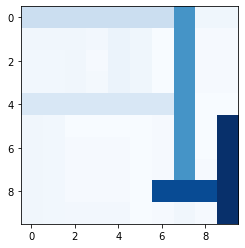

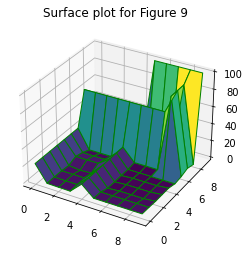

In [11]:
# importing libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

region_action_scores = []
for learner in team.learners:
    if learner.program.rule.value_set[0] > learner.program.rule.value_set[1]:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[0], 'q': learner.program.rule.value_set[0]})
    else:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[1], 'q': learner.program.rule.value_set[1]})

sorted_region_action_scores = sorted(region_action_scores, key=lambda value: float(value['q']), reverse=True)
# print(sorted_region_action_scores)
# for record in sorted_region_action_scores:
#     print(record)
action_states = []
for record in sorted_region_action_scores:
    action = ''
    if record['action'] == 0:
        action = '\u2191'
    elif record['action'] == 1:
        action = '\u2193'
    elif record['action'] == 2:
        action = '\u2192'
    elif record['action'] == 3:
        action = '\u2190'

    for i in range(record['region'][3] - record['region'][2]+1):
        state = [0, 0]
        state[record['region'][0]] = record['region'][1]
        state[not record['region'][0]] = record['region'][2] + i
        
        # ensure we do not enter duplicate states
        found = 0
        for pair in action_states:
            if pair['state'] == (state[0], state[1]):
                found = 1
                
        if found == 0:
            action_states.append({'state': (state[0], state[1]), 'action': action, 'q': record['q'] })

# add in the rest of the states, either they are not visited, or illegal
for n in reversed(range(env.rows)):
    for m in range(env.cols):
        action = ''
        found = 0
        for record in action_states:
            if record['state'] == (n, m):
                found = 1
                action = record['action']
#                 action = float(round(record['q'], 0))
        if found == 0:
            if not env.check_legal((n, m)):
                action = 'X'
            else:
                action = '?'
        print(f'{action} ', end='')
    print('\n')
    

q_map = np.zeros((env.rows, env.cols))

# add in the rest of the states, either they are not visited, or illegal
for n in range(env.rows):
    for m in range(env.cols):
        action = ''
        found = 0
        for record in action_states:
            if record['state'] == (n, m):
                found = 1
                action = record['q']
        if found == 0:
            if not env.check_legal((n, m)):
                action = -1
            else:
                action = 0
        q_map[(env.rows-1)-n][m] = action

plt.imshow(q_map, cmap='Blues', interpolation='nearest')
plt.show()

x = []
y = []
for i in range(env.cols):
    x.append(i)
    y.append(i)

Y, X = np.meshgrid(x, y)

fig = plt.figure()

# syntax for 3-D plotting
ax = plt.axes(projection ='3d')

# syntax for plotting
ax.plot_surface(X, Y, q_map, cmap ='viridis', edgecolor ='green')
ax.set_title(f'Surface plot for {envName}')
plt.show()

## Heatmap (RL)

In [12]:
region_action_scores = []
for learner in team.learners:
    if learner.program.rule.value_set[0] > learner.program.rule.value_set[1]:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[0], 'q': learner.program.rule.value_set[0]})
    else:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[1], 'q': learner.program.rule.value_set[1]})

sorted_region_action_scores = sorted(region_action_scores, key=lambda value: float(value['q']), reverse=True)

state_counts = []

for n in reversed(range(env.rows)):
    for m in range(env.cols):
        state_count = 0
        for record in sorted_region_action_scores:
            for i in range(record['region'][3] - record['region'][2]+1):
                state = [0, 0]
                state[record['region'][0]] = record['region'][1]
                state[not record['region'][0]] = record['region'][2] + i

                if state == [n, m]:
                    state_count += 1
                # state count logic goes here
        state_counts.append({'state': (n, m), 'count': state_count})

for n in reversed(range(env.rows)):
    for m in range(env.cols):
        for record in state_counts:
            if (n, m) == record['state']:
                count = record['count']
                print(f'{count} ', end='')
    print('')

14 11 12 9 9 10 8 11 10 10 
7 6 7 4 5 3 0 4 0 0 
7 3 5 1 4 1 0 4 0 0 
7 6 5 4 7 4 0 4 0 0 
10 8 8 8 9 7 7 8 0 0 
7 2 0 0 0 0 1 4 0 1 
6 3 1 1 1 0 1 3 0 1 
7 3 0 0 0 0 1 4 0 1 
6 4 1 1 1 0 2 4 1 1 
6 4 1 1 1 0 1 3 0 1 
